In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def glycolysis_model(
    t,
    J0=2.5,
    k1=100,
    k2=6,
    k3=16,
    k4=100,
    k5=1.28,
    k6=12,
    k=1.8,
    kappa=13,
    q=4,
    K1=0.52,
    psi=0.1,
    N=1,
    A=4,
):
    def func(x, t):
        v1 = k1 * x[0] * x[5] / (1 + (x[5] / K1) ** q)
        v2 = k2 * x[1] * (N - x[4])
        v3 = k3 * x[2] * (A - x[5])
        v4 = k4 * x[3] * x[4]
        v5 = k5 * x[5]
        v6 = k6 * x[1] * x[4]
        v7 = k * x[6]
        J = kappa * (x[3] - x[6])
        return [
            J0 - v1,
            2 * v1 - v2 - v6,
            v2 - v3,
            v3 - v4 - J,
            v2 - v4 - v6,
            -2 * v1 + 2 * v3 - v5,
            psi * J - v7,
        ]

    x0 = [
        0.50144272,
        1.95478666,
        0.19788759,
        0.14769148,
        0.16059078,
        0.16127341,
        0.06404702,
    ]
    return odeint(func, x0, t)

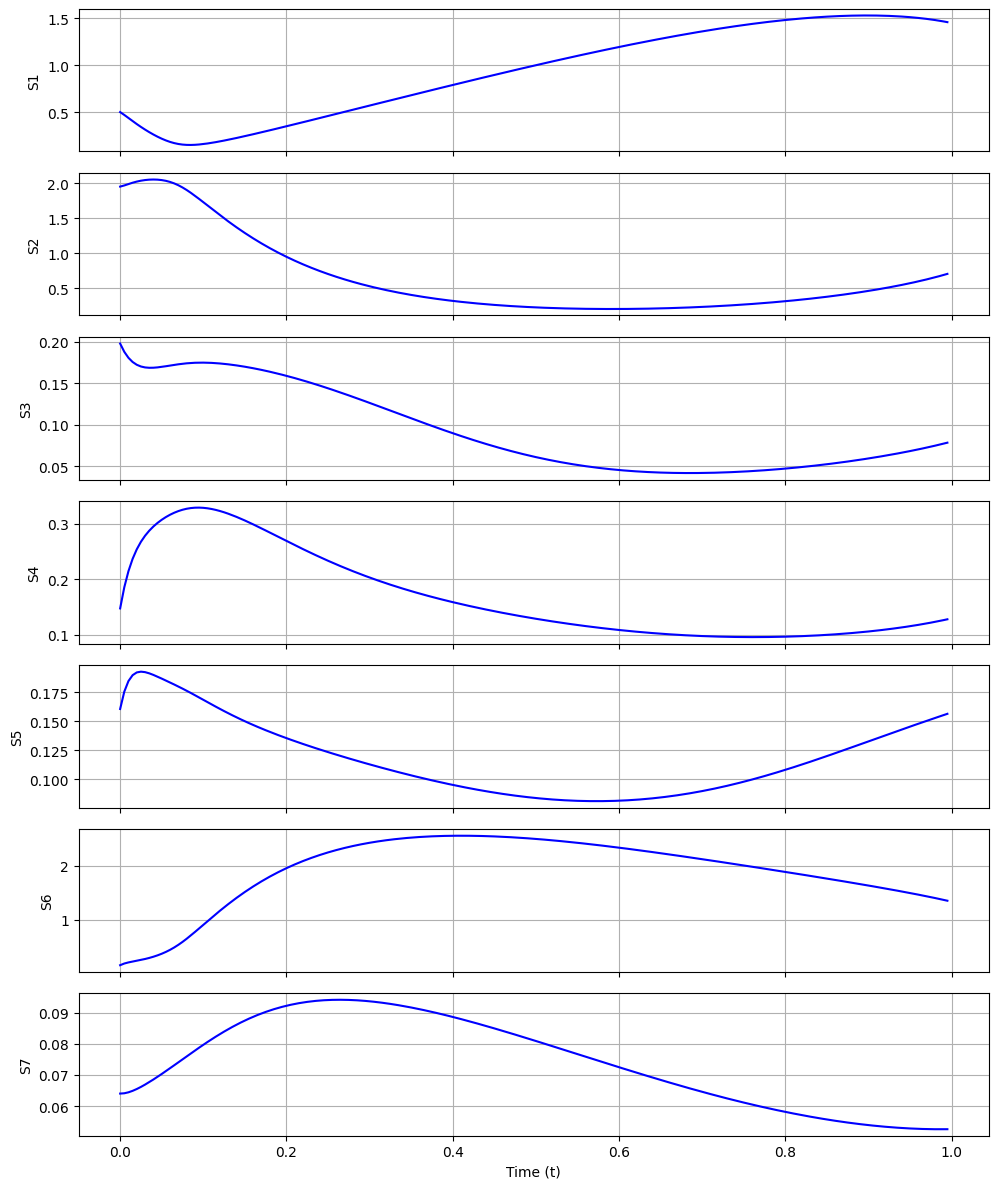

In [3]:
t = np.arange(0, 1, 0.005)[:, None]
y = glycolysis_model(np.ravel(t))

t_flat = t.flatten()  
fig, axs = plt.subplots(7, 1, figsize=(10, 12), sharex=True)
for i in range(7):
    axs[i].plot(t_flat, y[:, i], c='blue')
    axs[i].set_ylabel(f'S{i+1}')
    axs[i].grid(True)
axs[-1].set_xlabel('Time (t)')
plt.tight_layout()
plt.show()

In [4]:
def ode_loss(t, model):
    
    J0 = 2.5
    k1, k2, k3, k4, k5, k6 = 100.0, 6.0, 16.0, 100.0, 1.28, 12.0
    k, kappa = 1.8, 13.0
    q, K1 = 4.0, 0.52
    psi, N, A = 0.1, 1.0, 4.0

    preds = model(t)
    S1 = preds[:, 0].view(-1, 1)
    S2 = preds[:, 1].view(-1, 1)
    S3 = preds[:, 2].view(-1, 1)
    S4 = preds[:, 3].view(-1, 1)
    S5 = preds[:, 4].view(-1, 1)
    S6 = preds[:, 5].view(-1, 1)
    S7 = preds[:, 6].view(-1, 1)

    dS1_dt = torch.autograd.grad(S1, t, torch.ones_like(S1), create_graph=True)[0]
    dS2_dt = torch.autograd.grad(S2, t, torch.ones_like(S2), create_graph=True)[0]
    dS3_dt = torch.autograd.grad(S3, t, torch.ones_like(S3), create_graph=True)[0]
    dS4_dt = torch.autograd.grad(S4, t, torch.ones_like(S4), create_graph=True)[0]
    dS5_dt = torch.autograd.grad(S5, t, torch.ones_like(S5), create_graph=True)[0]
    dS6_dt = torch.autograd.grad(S6, t, torch.ones_like(S6), create_graph=True)[0]
    dS7_dt = torch.autograd.grad(S7, t, torch.ones_like(S7), create_graph=True)[0]

    v1 = k1 * S1 * S6 / (1 + (S6 / K1) ** q)
    v2 = k2 * S2 * (N - S5)
    v3 = k3 * S3 * (A - S6)
    v4 = k4 * S4 * S5
    v5 = k5 * S6
    v6 = k6 * S2 * S5
    v7 = k * S7
    J = kappa * (S4 - S7)

    res1 = dS1_dt - (J0 - v1)
    res2 = dS2_dt - (2 * v1 - v2 - v6)
    res3 = dS3_dt - (v2 - v3)
    res4 = dS4_dt - (v3 - v4 - J)
    res5 = dS5_dt - (v2 - v4 - v6)
    res6 = dS6_dt - (-2 * v1 + 2 * v3 - v5)
    res7 = dS7_dt - (psi * J - v7)

    loss = torch.mean(res1**2 + res2**2 + res3**2 + res4**2 + res5**2 + res6**2 + res7**2)

    return loss

In [27]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=2):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.sine_coeff = nn.Parameter(torch.randn(num_features, 1))   
        self.cosine_coeff = nn.Parameter(torch.randn(num_features, 1))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat
    
class TimeFeatureLayer(nn.Module):
    def __init__(self):
        super(TimeFeatureLayer, self).__init__()

    def forward(self, t):
        feat = [t]
        for i in range(6):
            feat.append(torch.sin((i+1) * t))
        return torch.cat(feat, dim=1)

class PinnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = FourierFeatureLayer()
        # self.feature = TimeFeatureLayer()
        self.layer1 = nn.Linear(in_features=4, out_features=40)
        self.tanh = nn.Tanh()
        # self.swish = Swish()
        self.layer2 = nn.Linear(in_features=40, out_features=40)
        self.layer3 = nn.Linear(in_features=40, out_features=40)
        self.layer4 = nn.Linear(in_features=40, out_features=7)

    def forward(self, x):
        return self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))

Training step: 0
Loss = 0.13756558299064636 | Initial loss = 0.6756405234336853 | Physics loss = 130.80917358398438


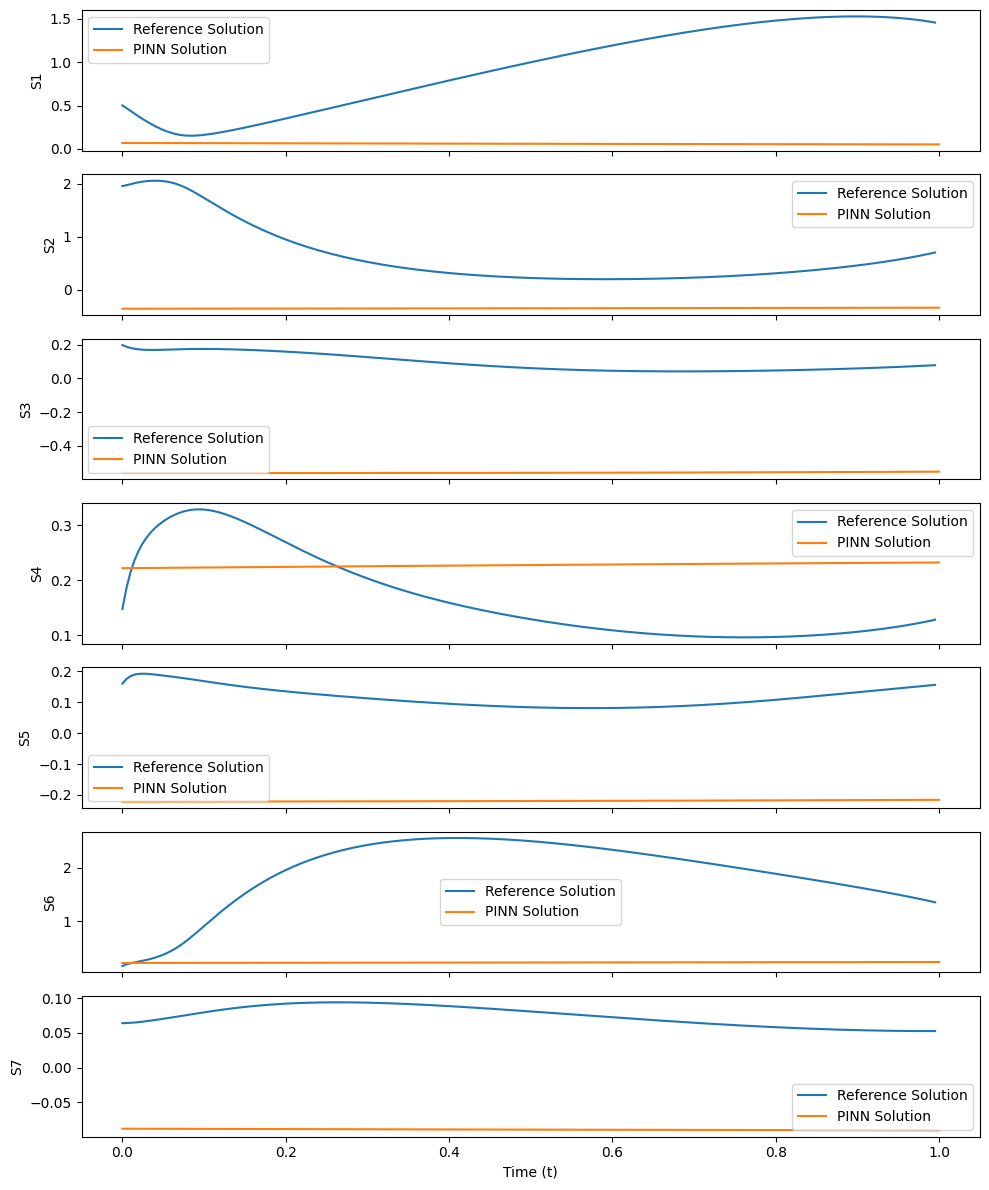

Training step: 1000
Loss = 0.0020824407692998648 | Initial loss = 0.14202319085597992 | Physics loss = 0.6622089147567749


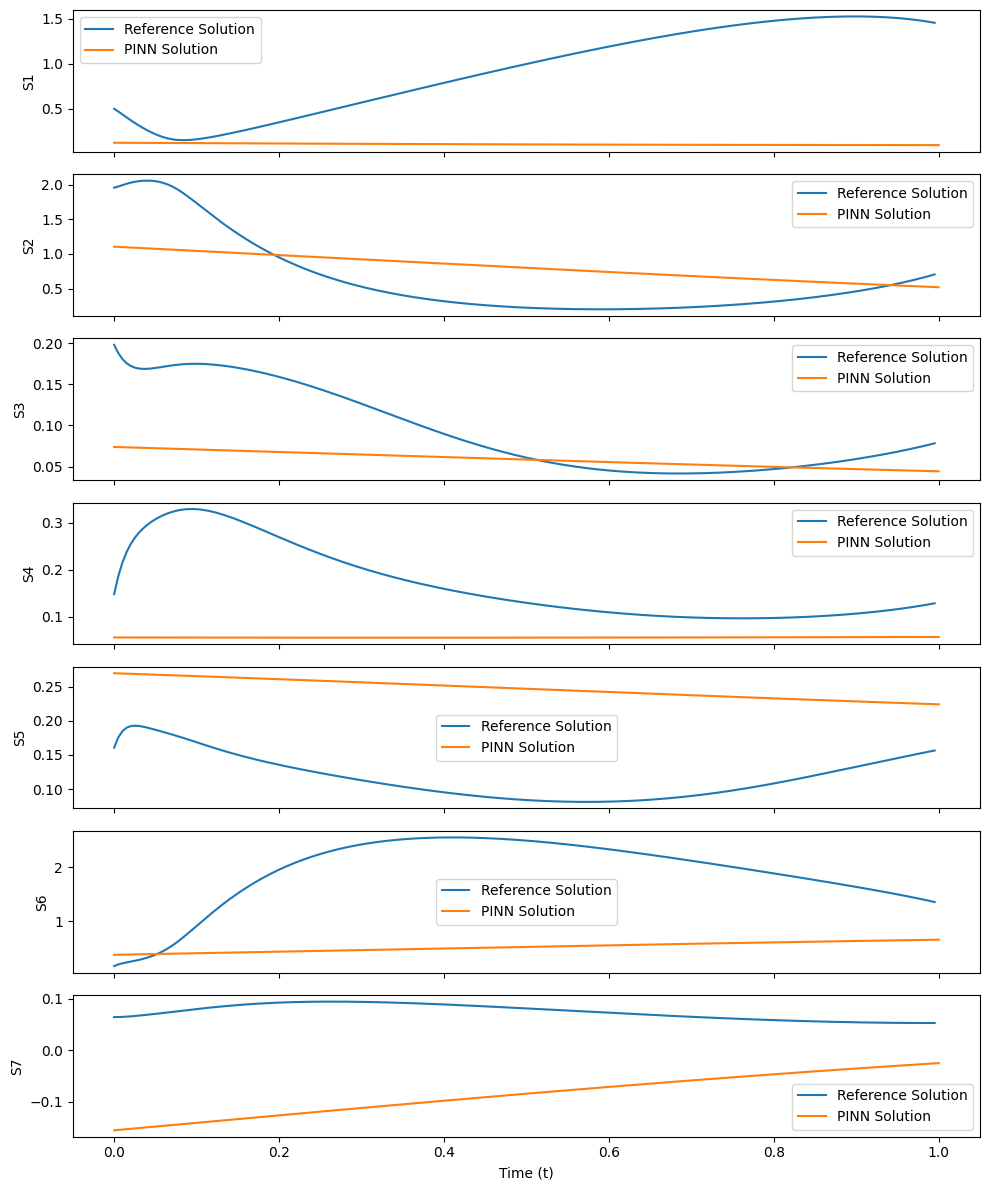

Training step: 2000
Loss = 0.0017259259475395083 | Initial loss = 0.06333580613136292 | Physics loss = 1.0925679206848145


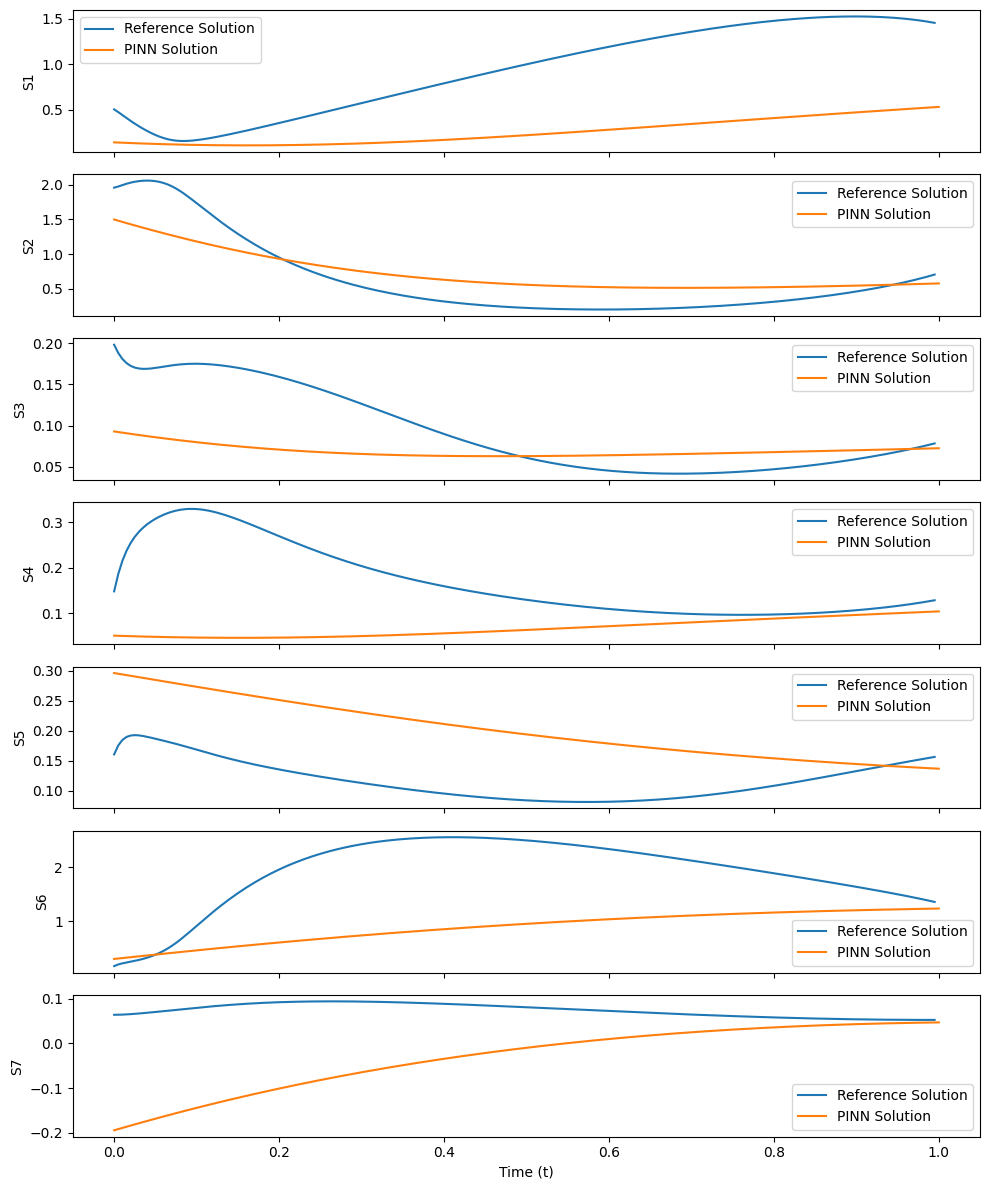

Training step: 3000
Loss = 0.0006406957982107997 | Initial loss = 0.03506459668278694 | Physics loss = 0.29004982113838196


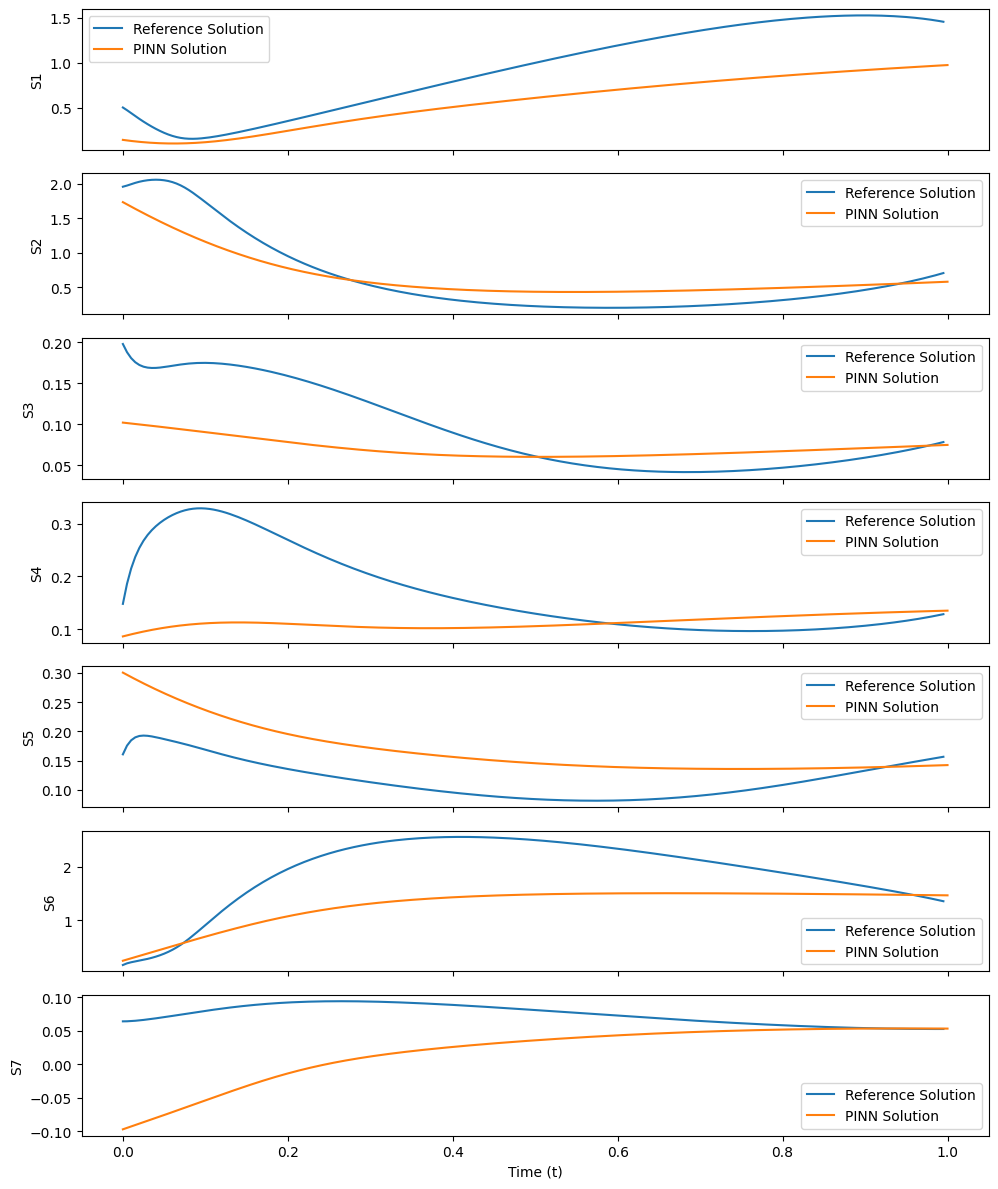

Training step: 4000
Loss = 0.0003538469027262181 | Initial loss = 0.02385835349559784 | Physics loss = 0.11526336520910263


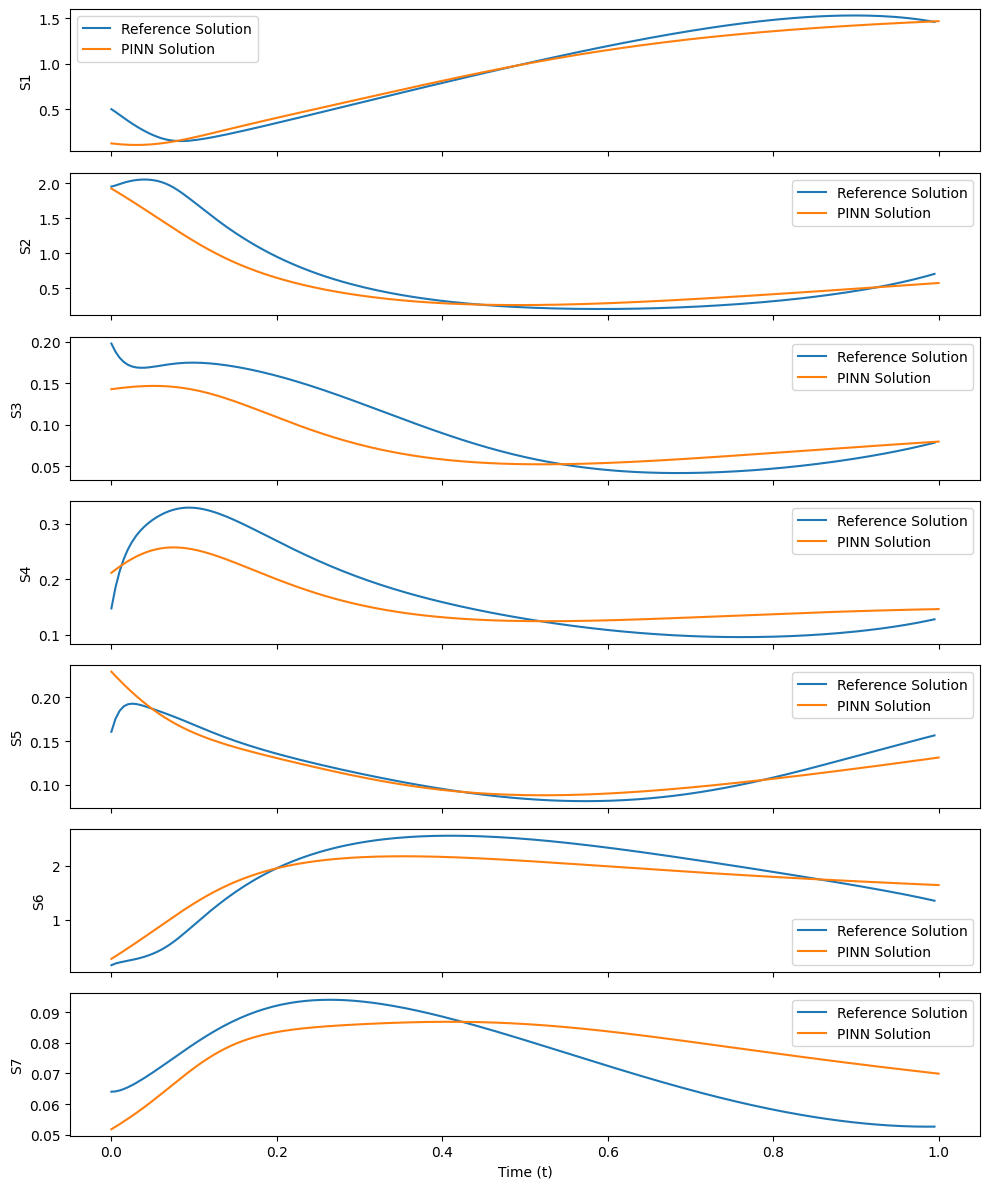

Training step: 5000
Loss = 0.00022173233446665108 | Initial loss = 0.013139468617737293 | Physics loss = 0.09033764898777008


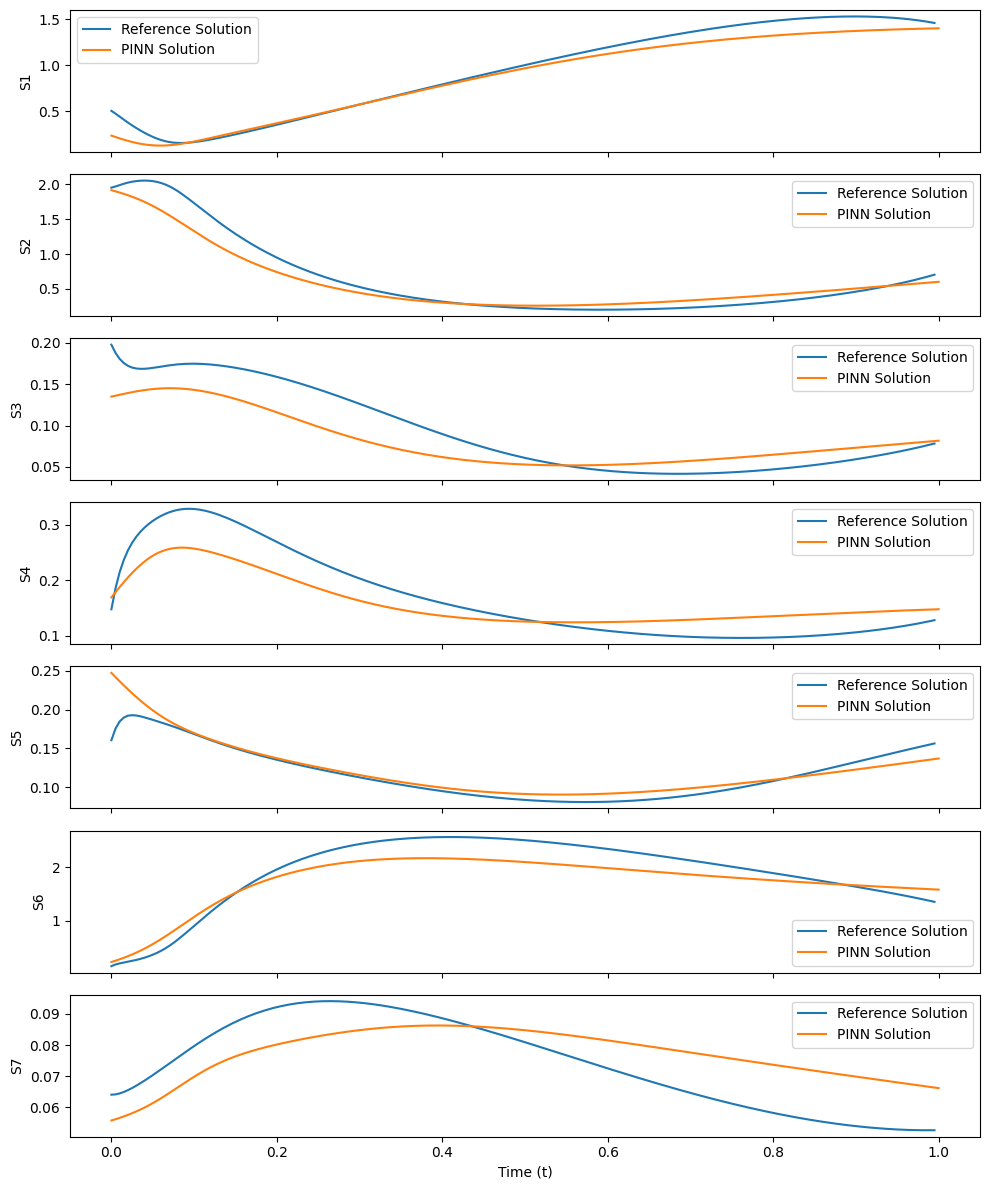

Training step: 6000
Loss = 0.0002746514801401645 | Initial loss = 0.016897844150662422 | Physics loss = 0.10567304491996765


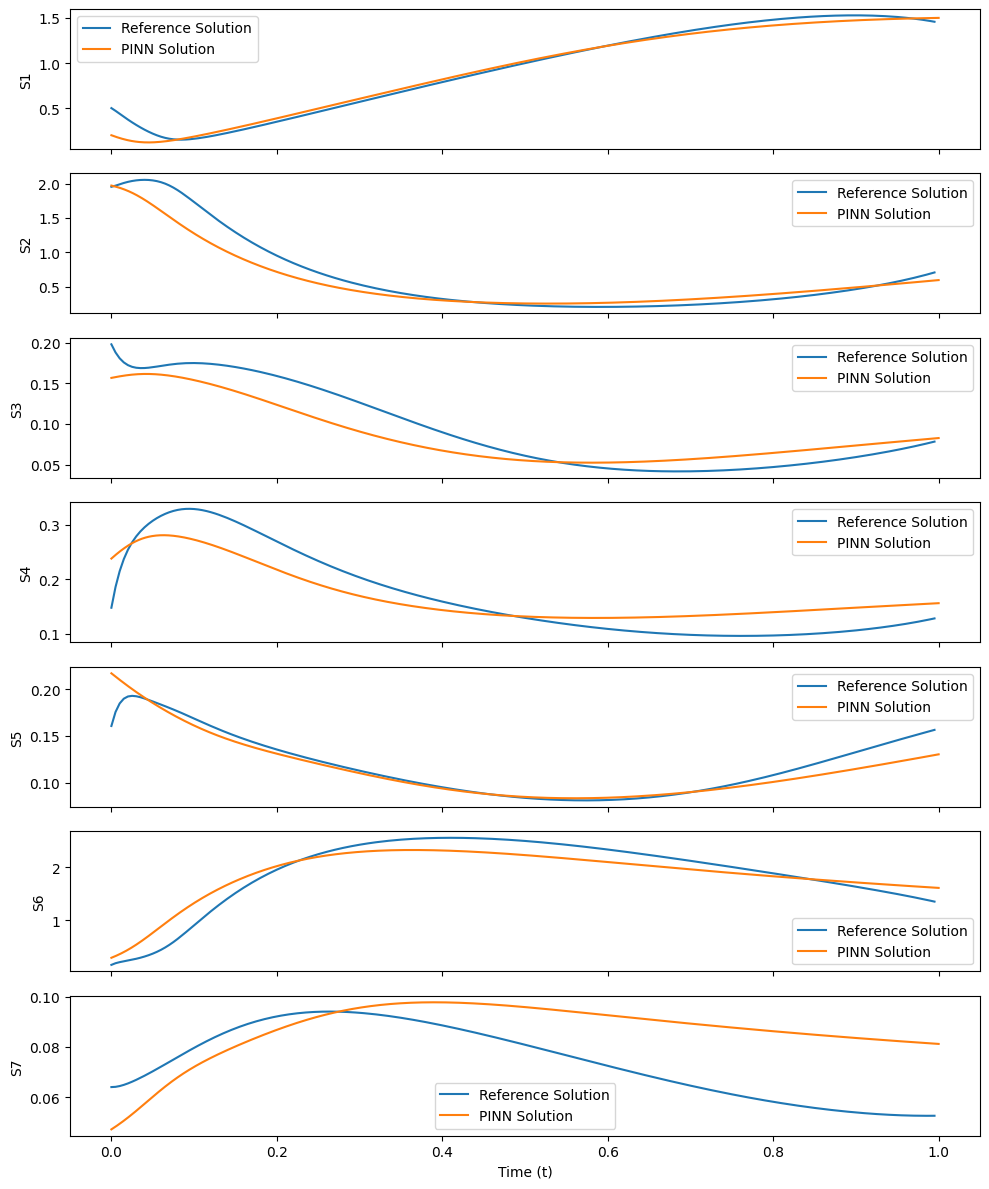

Training step: 7000
Loss = 6.497390131698921e-05 | Initial loss = 0.0028184542898088694 | Physics loss = 0.03678935766220093


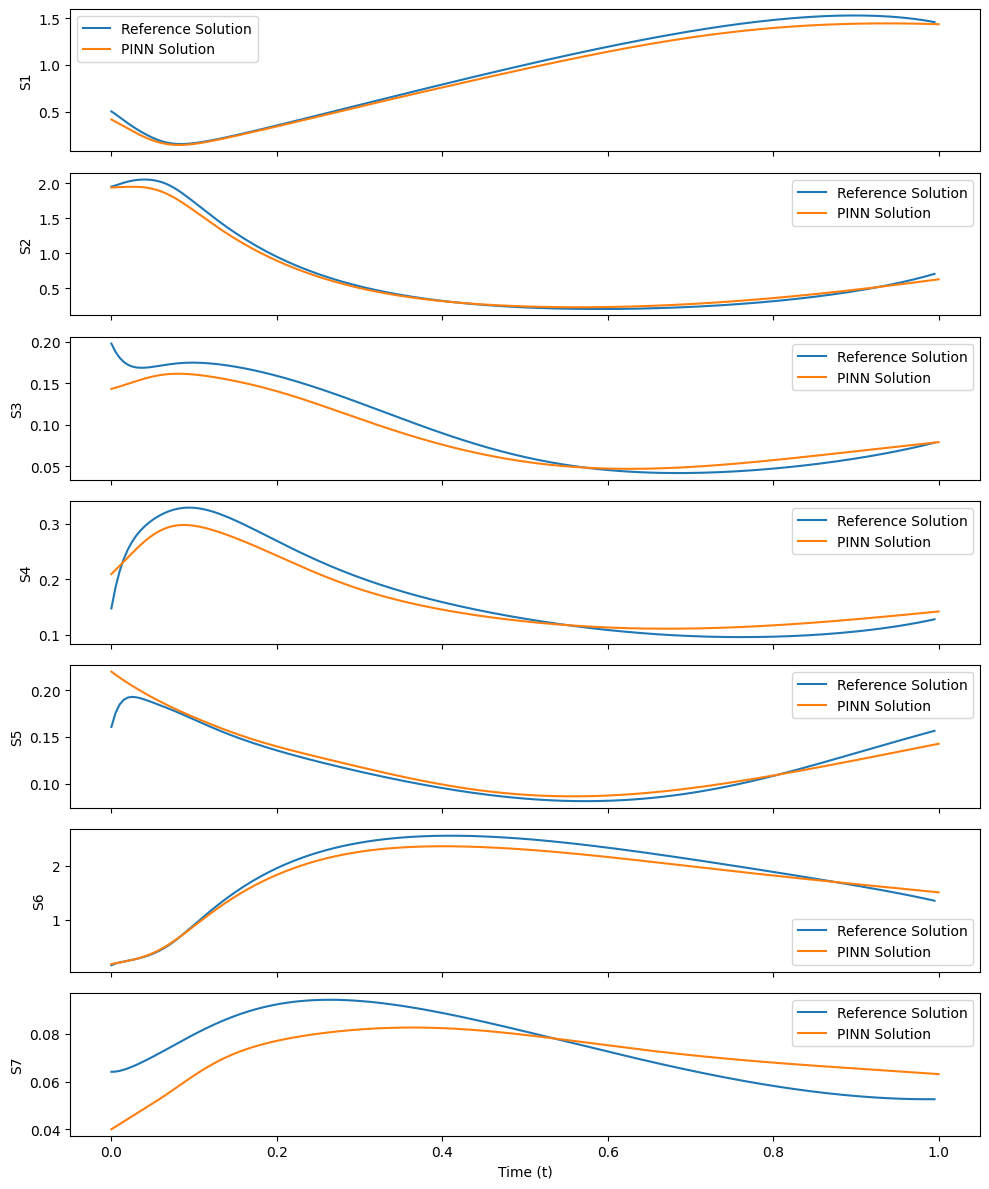

Training step: 8000
Loss = 8.705241634743288e-05 | Initial loss = 0.0030638750176876783 | Physics loss = 0.056413665413856506


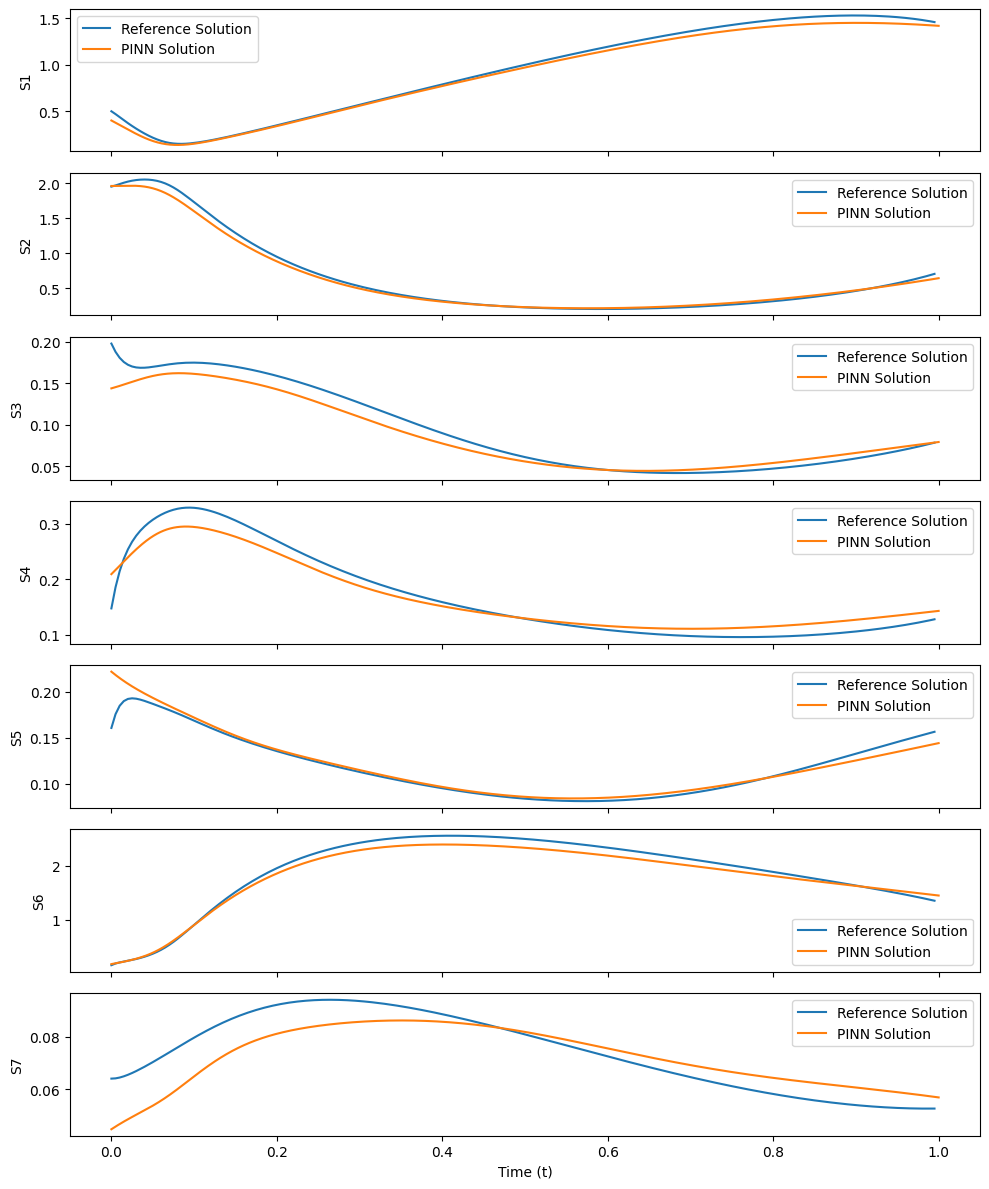

Training step: 9000
Loss = 0.00019295053789392114 | Initial loss = 0.0019399800803512335 | Physics loss = 0.17355072498321533


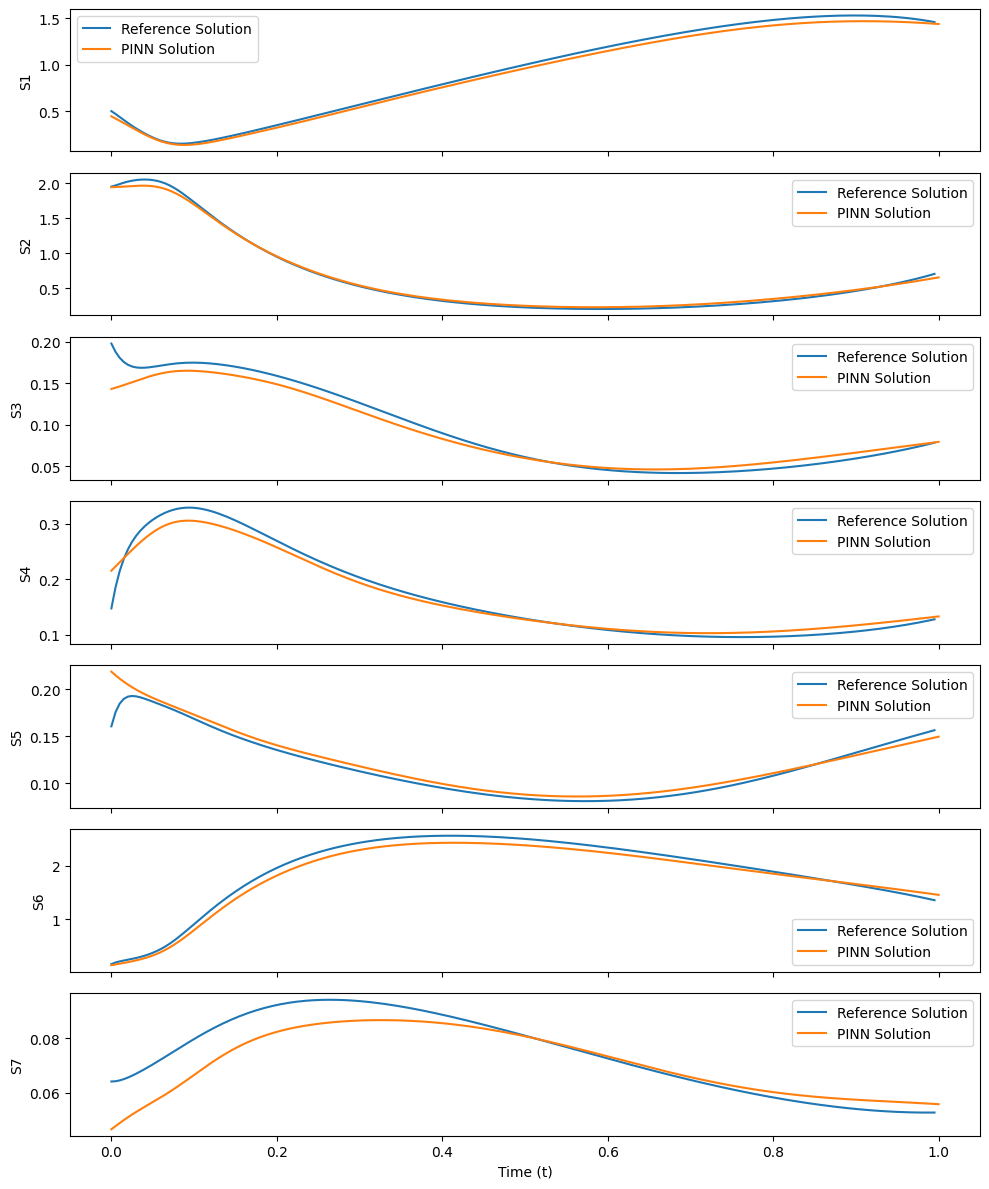

Training step: 10000
Loss = 3.845787432510406e-05 | Initial loss = 0.0019127082778140903 | Physics loss = 0.019330790266394615


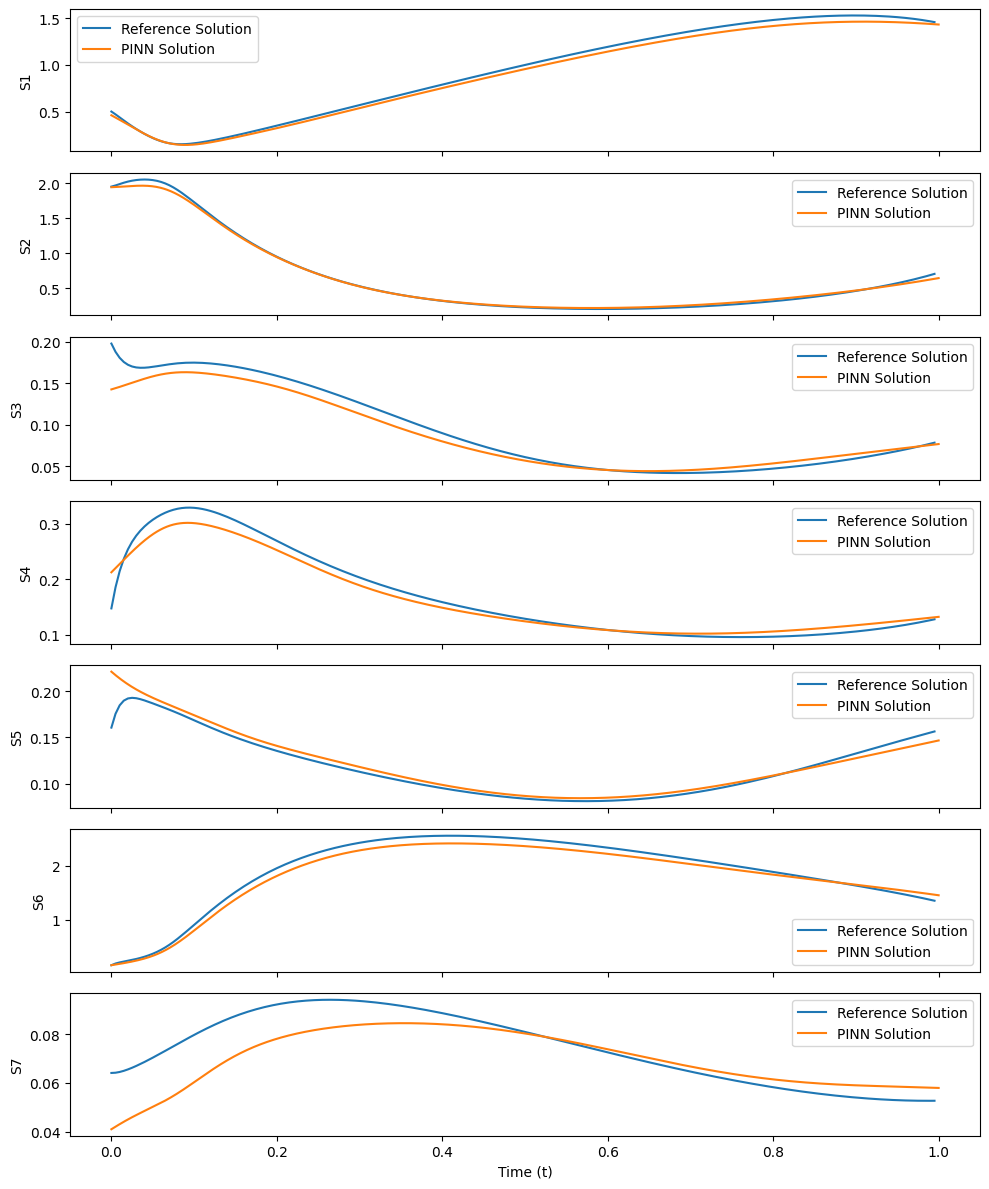

In [28]:
torch.manual_seed(42)
pinn = PinnModel()

time = torch.linspace(0, 1, 1000).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 1, 100, requires_grad=True).view(-1, 1)

S0 = torch.tensor([
        0.50144272,
        1.95478666,
        0.19788759,
        0.14769148,
        0.16059078,
        0.16127341,
        0.06404702,
    ])

optimiser = torch.optim.Adam(pinn.parameters(), lr=0.01)
epochs = 10001

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Initial Loss
    S_initial = pinn(t_initial)
    loss1 = torch.mean((S_initial.squeeze() - S0)**2)

    # Physics Loss
    loss2 = ode_loss(t_physics, pinn)

    # Total Loss
    loss = 1e-2*loss1 + 1e-3*loss2

    loss.backward()
    optimiser.step()

    if i % 1000 == 0:
        
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Initial loss = {loss1} | Physics loss = {loss2}")

        pinn.eval()
        with torch.inference_mode():
            S = pinn(time)

        time_flat = time.squeeze()
        
        fig, axs = plt.subplots(7, 1, figsize=(10, 12), sharex=True)
        for i in range(7):
            axs[i].plot(t_flat, y[:, i], label="Reference Solution")
            axs[i].plot(time_flat, S[:, i].detach(), label="PINN Solution")
            axs[i].set_ylabel(f'S{i+1}')
            axs[i].legend()
        axs[-1].set_xlabel('Time (t)')
        plt.tight_layout()
        plt.show()